<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_08_ProjEight_GeneralizedLinearModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libs

In [106]:
!pip install -q import_ipynb

In [107]:
# utils
import os, sys, warnings, itertools
import import_ipynb
import pandas as pd
import numpy as np
from tqdm import tqdm
# colab
from google.colab import drive
# sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (FunctionTransformer,
                                   KBinsDiscretizer,
                                   OneHotEncoder,
                                   StandardScaler,
                                   OrdinalEncoder)
from sklearn.dummy import DummyRegressor
from sklearn.utils import gen_even_slices
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor, Ridge
from sklearn.metrics import (mean_absolute_error,
                             mean_poisson_deviance,
                             mean_squared_error,
                             auc)
# vis
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
print("python version:", sys.version)
print("sklearn version:", sklearn.__version__)

python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
sklearn version: 1.5.2


## Setting

In [109]:
warnings.filterwarnings('ignore')

In [110]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [111]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
# working directory
working_dir = '/content/drive/MyDrive/Jupyter Notebooks/'
os.chdir(working_dir)

In [113]:
# load MachineLearningUtils
from MachineLearningUtils import *

## Dataset

In [114]:
df = fetch_openml(data_id=41214, as_frame=True, parser="pandas").frame

In [115]:
summarize_columns(df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,IDpol,float64,0,0.0,678013,1.0,3.0,5.0
1,ClaimNb,int64,0,0.0,11,1,1,1
2,Exposure,float64,0,0.0,181,0.1,0.77,0.75
3,Area,category,0,0.0,6,D,D,B
4,VehPower,int64,0,0.0,12,5,5,6
5,VehAge,int64,0,0.0,78,0,0,2
6,DrivAge,int64,0,0.0,83,55,55,52
7,BonusMalus,int64,0,0.0,115,50,50,50
8,VehBrand,category,0,0.0,11,B12,B12,B12
9,VehGas,object,0,0.0,2,'Regular','Regular','Diesel'


In [116]:
display_df(df)

Dataframe:  
num_rows = 678,013 
num_cols = 12


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   IDpol       678013 non-null  float64 
 1   ClaimNb     678013 non-null  int64   
 2   Exposure    678013 non-null  float64 
 3   Area        678013 non-null  category
 4   VehPower    678013 non-null  int64   
 5   VehAge      678013 non-null  int64   
 6   DrivAge     678013 non-null  int64   
 7   BonusMalus  678013 non-null  int64   
 8   VehBrand    678013 non-null  category
 9   VehGas      678013 non-null  object  
 10  Density     678013 non-null  int64   
 11  Region      678013 non-null  category
dtypes: category(3), float64(2), int64(6), object(1)
memory usage: 48.5+ MB


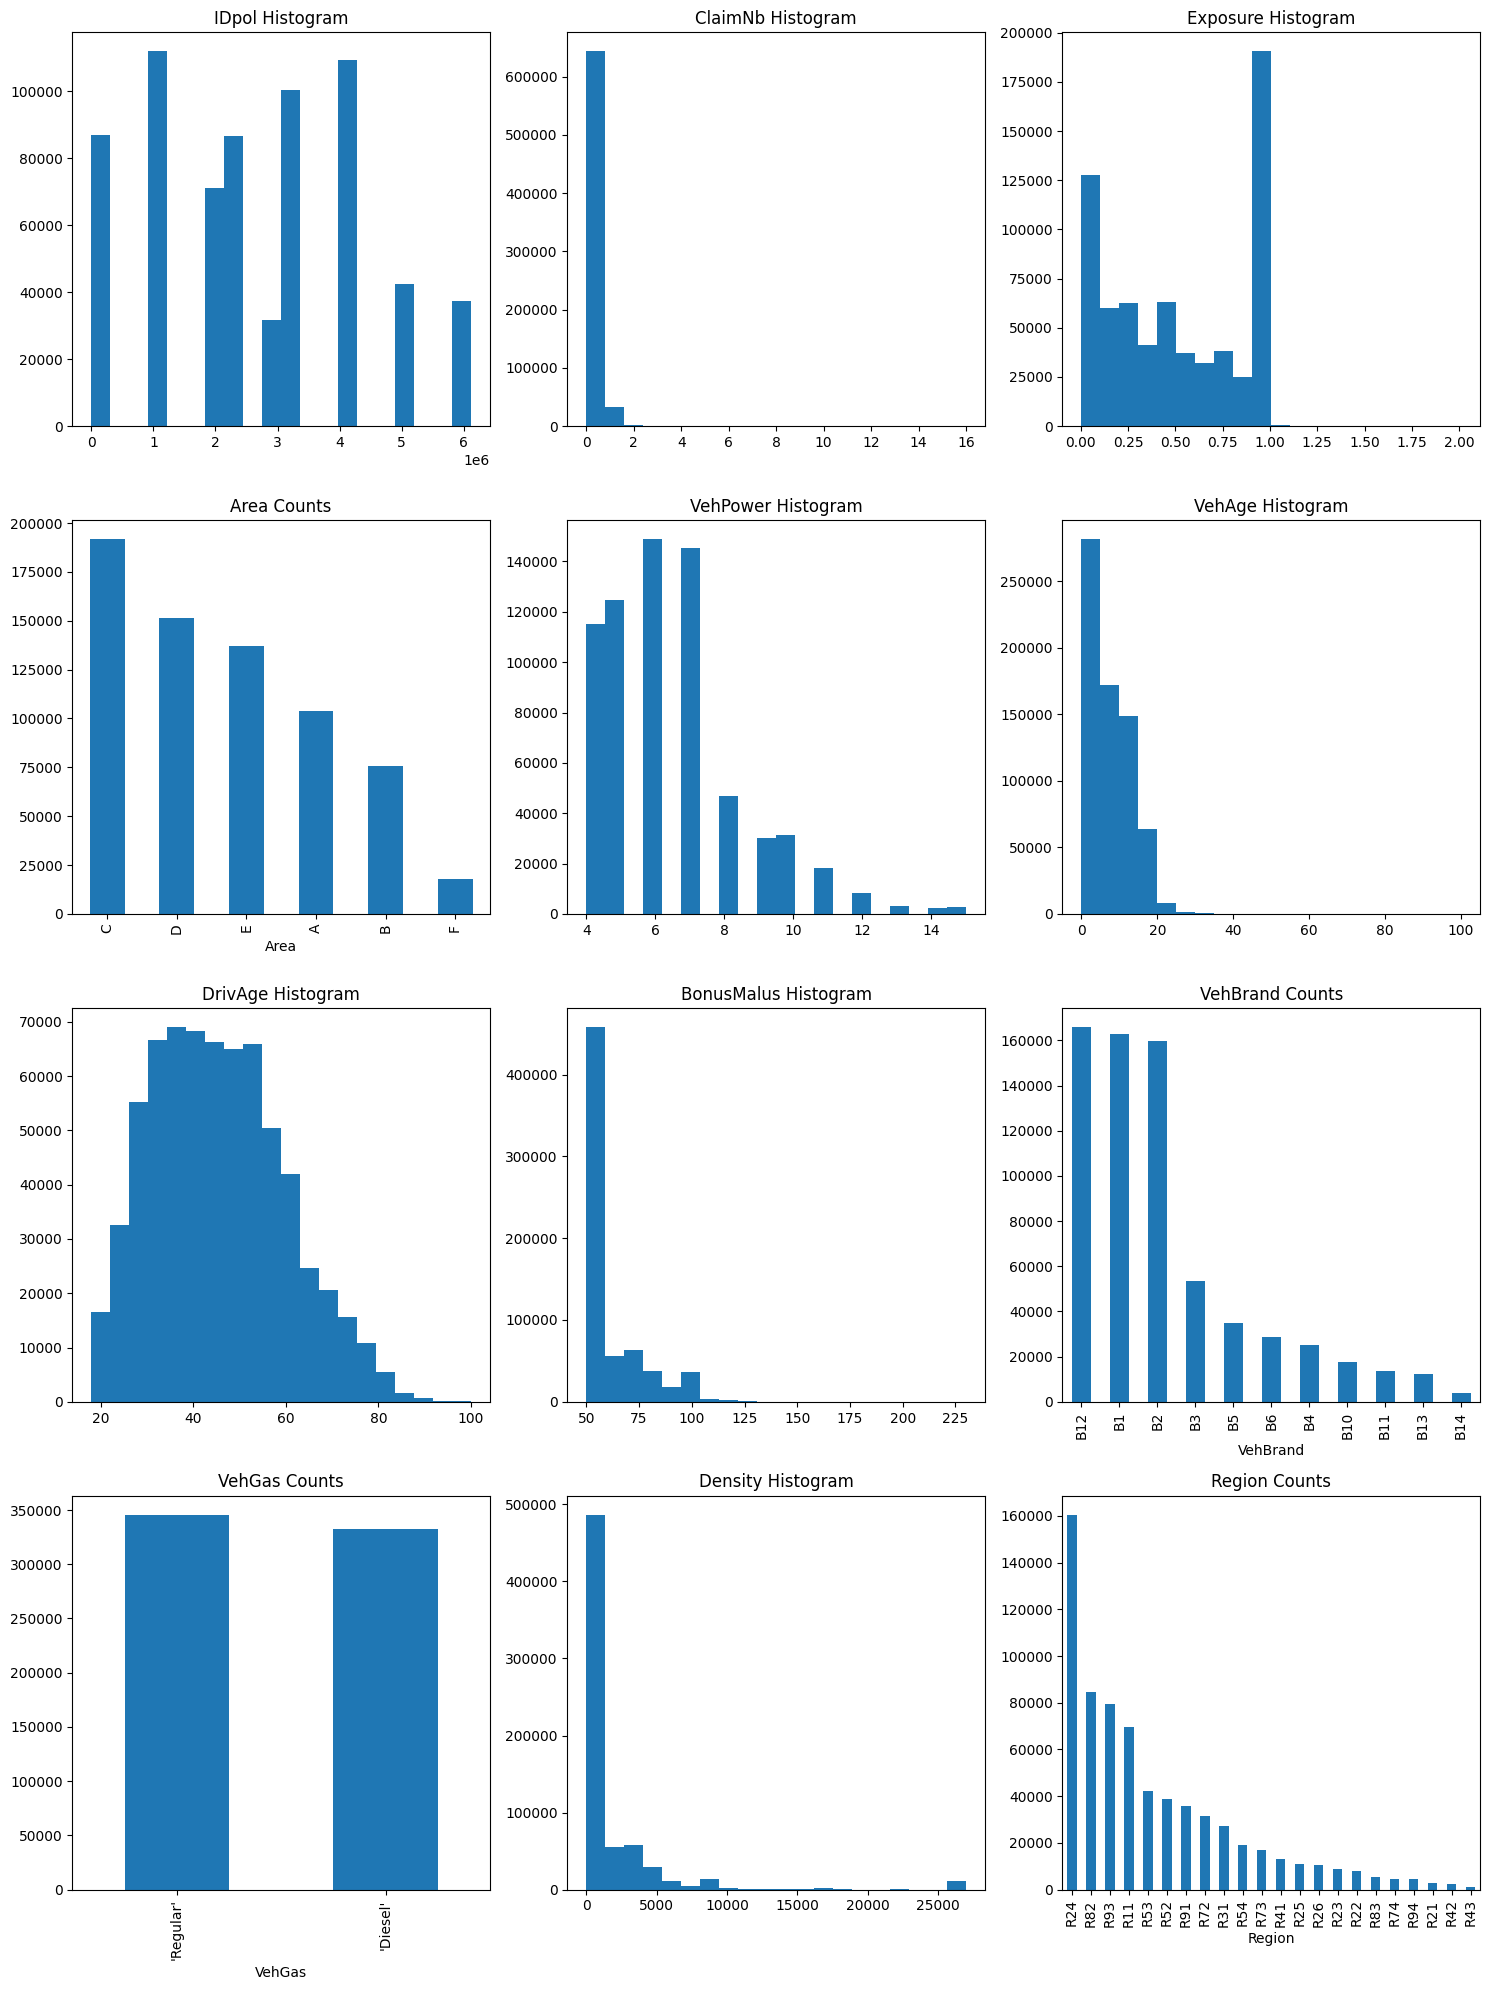

In [117]:
cols = list(df.columns)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
numerical_features = [col for col in cols if col not in categorical_cols]

plot_variables(df=df,
               vars_to_plot=cols,
               cts_vars=numerical_features,
               num_cols=3,
               hist_num_bins=20)

Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


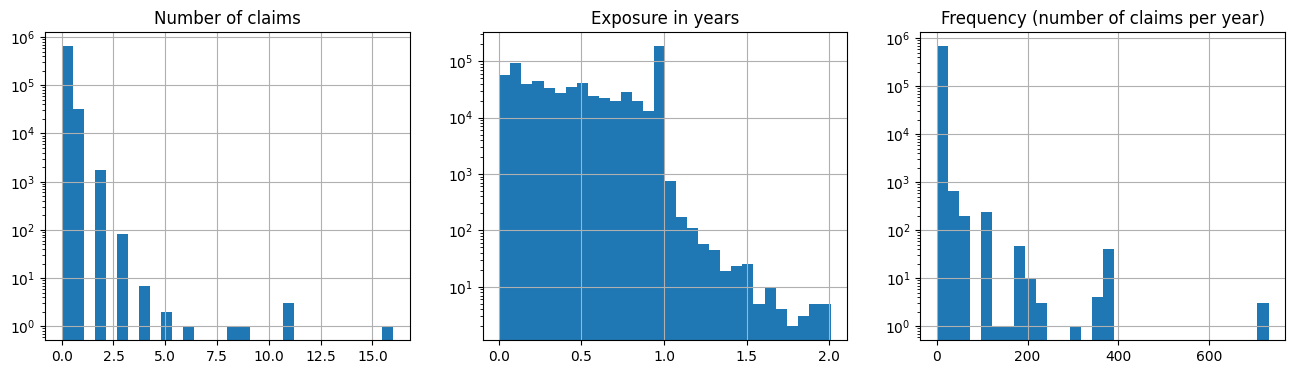

In [118]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"])))
print("Fraction of exposure with zero claims = {0:.1%}".format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

In [119]:
log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
    )

## Develop Model

In [120]:
def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""

    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f" % mean_squared_error(df_test["Frequency"],
                                         y_pred,
                                         sample_weight=df_test["Exposure"]
                                         )
        )

    print(
        "MAE: %.3f" % mean_absolute_error(df_test["Frequency"],
                                          y_pred,
                                          sample_weight=df_test["Exposure"]
                                          )
        )

    # ignore non-positive predictions, as they are invalid for the Poisson deviance

    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f" % mean_poisson_deviance(df_test["Frequency"][mask],
                                                              y_pred[mask],
                                                              sample_weight=df_test["Exposure"][mask],
                                                              )
        )

In [121]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

In [122]:
dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
    ).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.559
MAE: 0.189
mean Poisson deviance: 0.624


In [123]:
ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
    ).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.555
MAE: 0.186
mean Poisson deviance: 0.595


In [124]:
n_samples = df_train.shape[0]
poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
    )
poisson_glm.fit(
    df_train,
    df_train["Frequency"],
    regressor__sample_weight=df_train["Exposure"]
    )

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.555
MAE: 0.186
mean Poisson deviance: 0.592


In [125]:
tree_preprocessor = ColumnTransformer(
    [
        (
            "categorical",
            OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("numeric", "passthrough", ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
    )
poisson_gbrt = Pipeline(
    [
        ("preprocessor", tree_preprocessor),
        ("regressor",
         HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=128),
        ),
    ]
    )

poisson_gbrt.fit(
    df_train,
    df_train["Frequency"],
    regressor__sample_weight=df_train["Exposure"]
    )

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.551
MAE: 0.182
mean Poisson deviance: 0.571


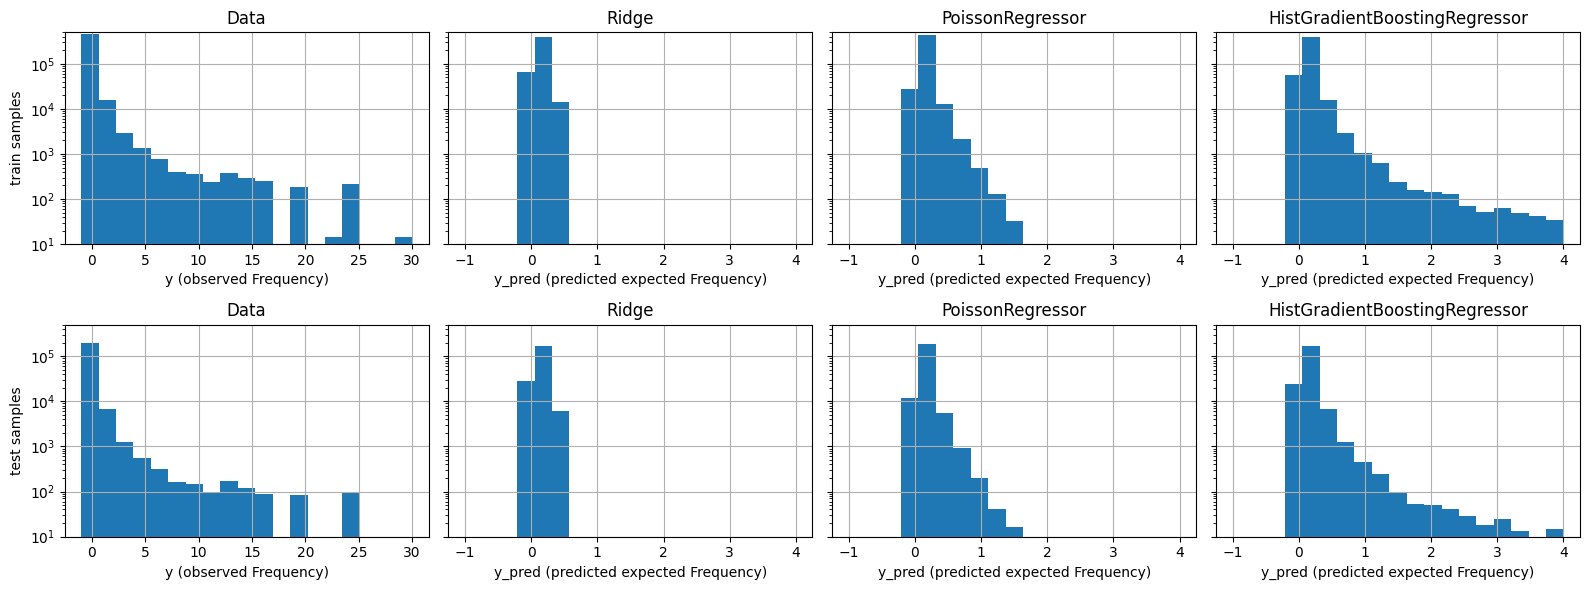

In [126]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20

for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):

    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
            )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
            )
plt.tight_layout()

Actual number of claims: 10814
Predicted number of claims by Ridge(alpha=1e-06): 10860.6
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 10859.9
Predicted number of claims by HistGradientBoostingRegressor(loss='poisson', max_leaf_nodes=128): 10948.3
Predicted number of claims by DummyRegressor(): 10868.9


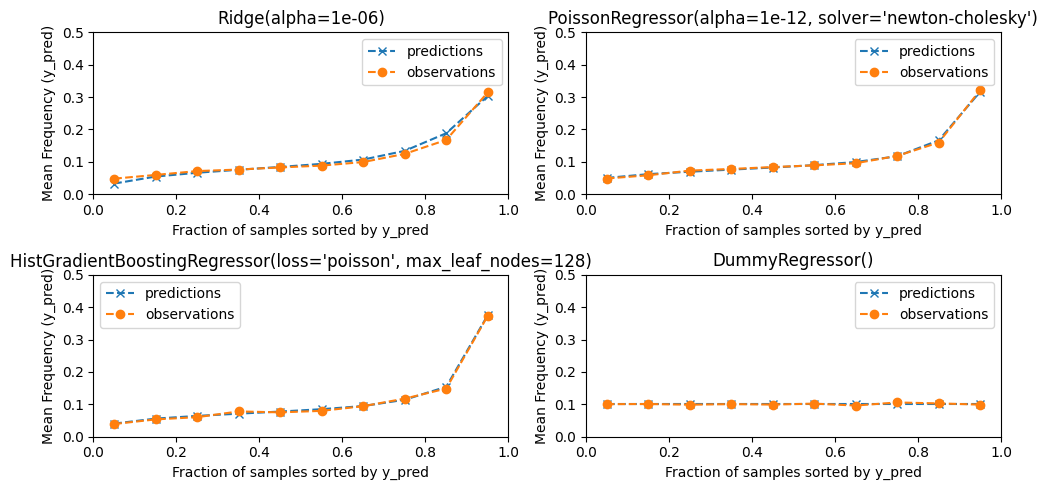

In [127]:
def mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """

    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin

print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, poisson_gbrt, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
        )

    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
        )
    axi.legend()
plt.tight_layout()

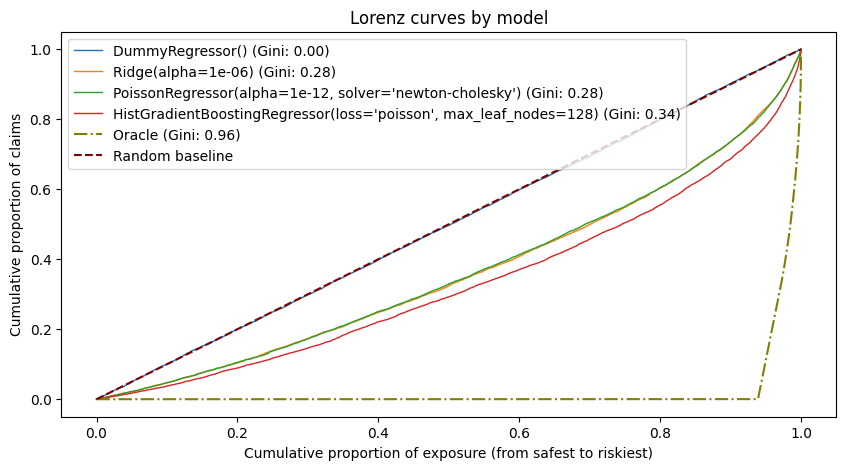

In [128]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    ranking = np.argsort(y_pred)
    ranked_frequencies = y_true[ranking]
    ranked_exposure = exposure[ranking]
    cumulated_claims = np.cumsum(ranked_frequencies * ranked_exposure)
    cumulated_claims /= cumulated_claims[-1]
    cumulated_exposure = np.cumsum(ranked_exposure)
    cumulated_exposure /= cumulated_exposure[-1]
    return cumulated_exposure, cumulated_claims

fig, ax = plt.subplots(figsize=(10, 5))

for model in [dummy, ridge_glm, poisson_glm, poisson_gbrt]:
    y_pred = model.predict(df_test)
    cum_exposure, cum_claims = lorenz_curve(
        df_test["Frequency"], y_pred, df_test["Exposure"]
        )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = "{} (Gini: {:.2f})".format(model[-1], gini)
    ax.plot(cum_exposure, cum_claims, linestyle="-", label=label, linewidth=1)

# oracle model: y_pred == y_test
cum_exposure, cum_claims = lorenz_curve(
    df_test["Frequency"], df_test["Frequency"], df_test["Exposure"]
    )
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="olive", label=label)

# random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="maroon", label="Random baseline")
ax.set(
    title="Lorenz curves by model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
    )
ax.legend(loc="upper left")
plt.show()